In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')
import gc

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))

In [5]:
df = pd.DataFrame()
for f in files:
    try:
        if df.empty:
            df = pd.read_csv(f)
        else:
            df = pd.concat([df,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [6]:
df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
df = df.set_index('Datetime')
df = df.drop(columns=['date','hour'])

In [7]:
#Question: Do we need to remove all pollutants with suffix '_24h'?
pollutant = set(df.type)
pollutant.remove('AQI')
pollutant = [p for p in pollutant if '24h' not in p]
df = df.loc[df['type'].isin(pollutant)]

In [8]:
#build a model for '万柳' first
subset = df.loc[:,['type','万柳']]
subset.sort_values(by = ['Datetime'])
subset = subset.pivot_table(values='万柳', index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

In [9]:
#filling missing hours
subset_augmented = subset.asfreq('h')
subset_augmented = subset_augmented.interpolate(method = 'linear')
#before April 2014, there is no extra data. Therefore we only use data after that time
subset_augmented = subset_augmented.dropna()

In [10]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.vector_ar.vecm import coint_johansen

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

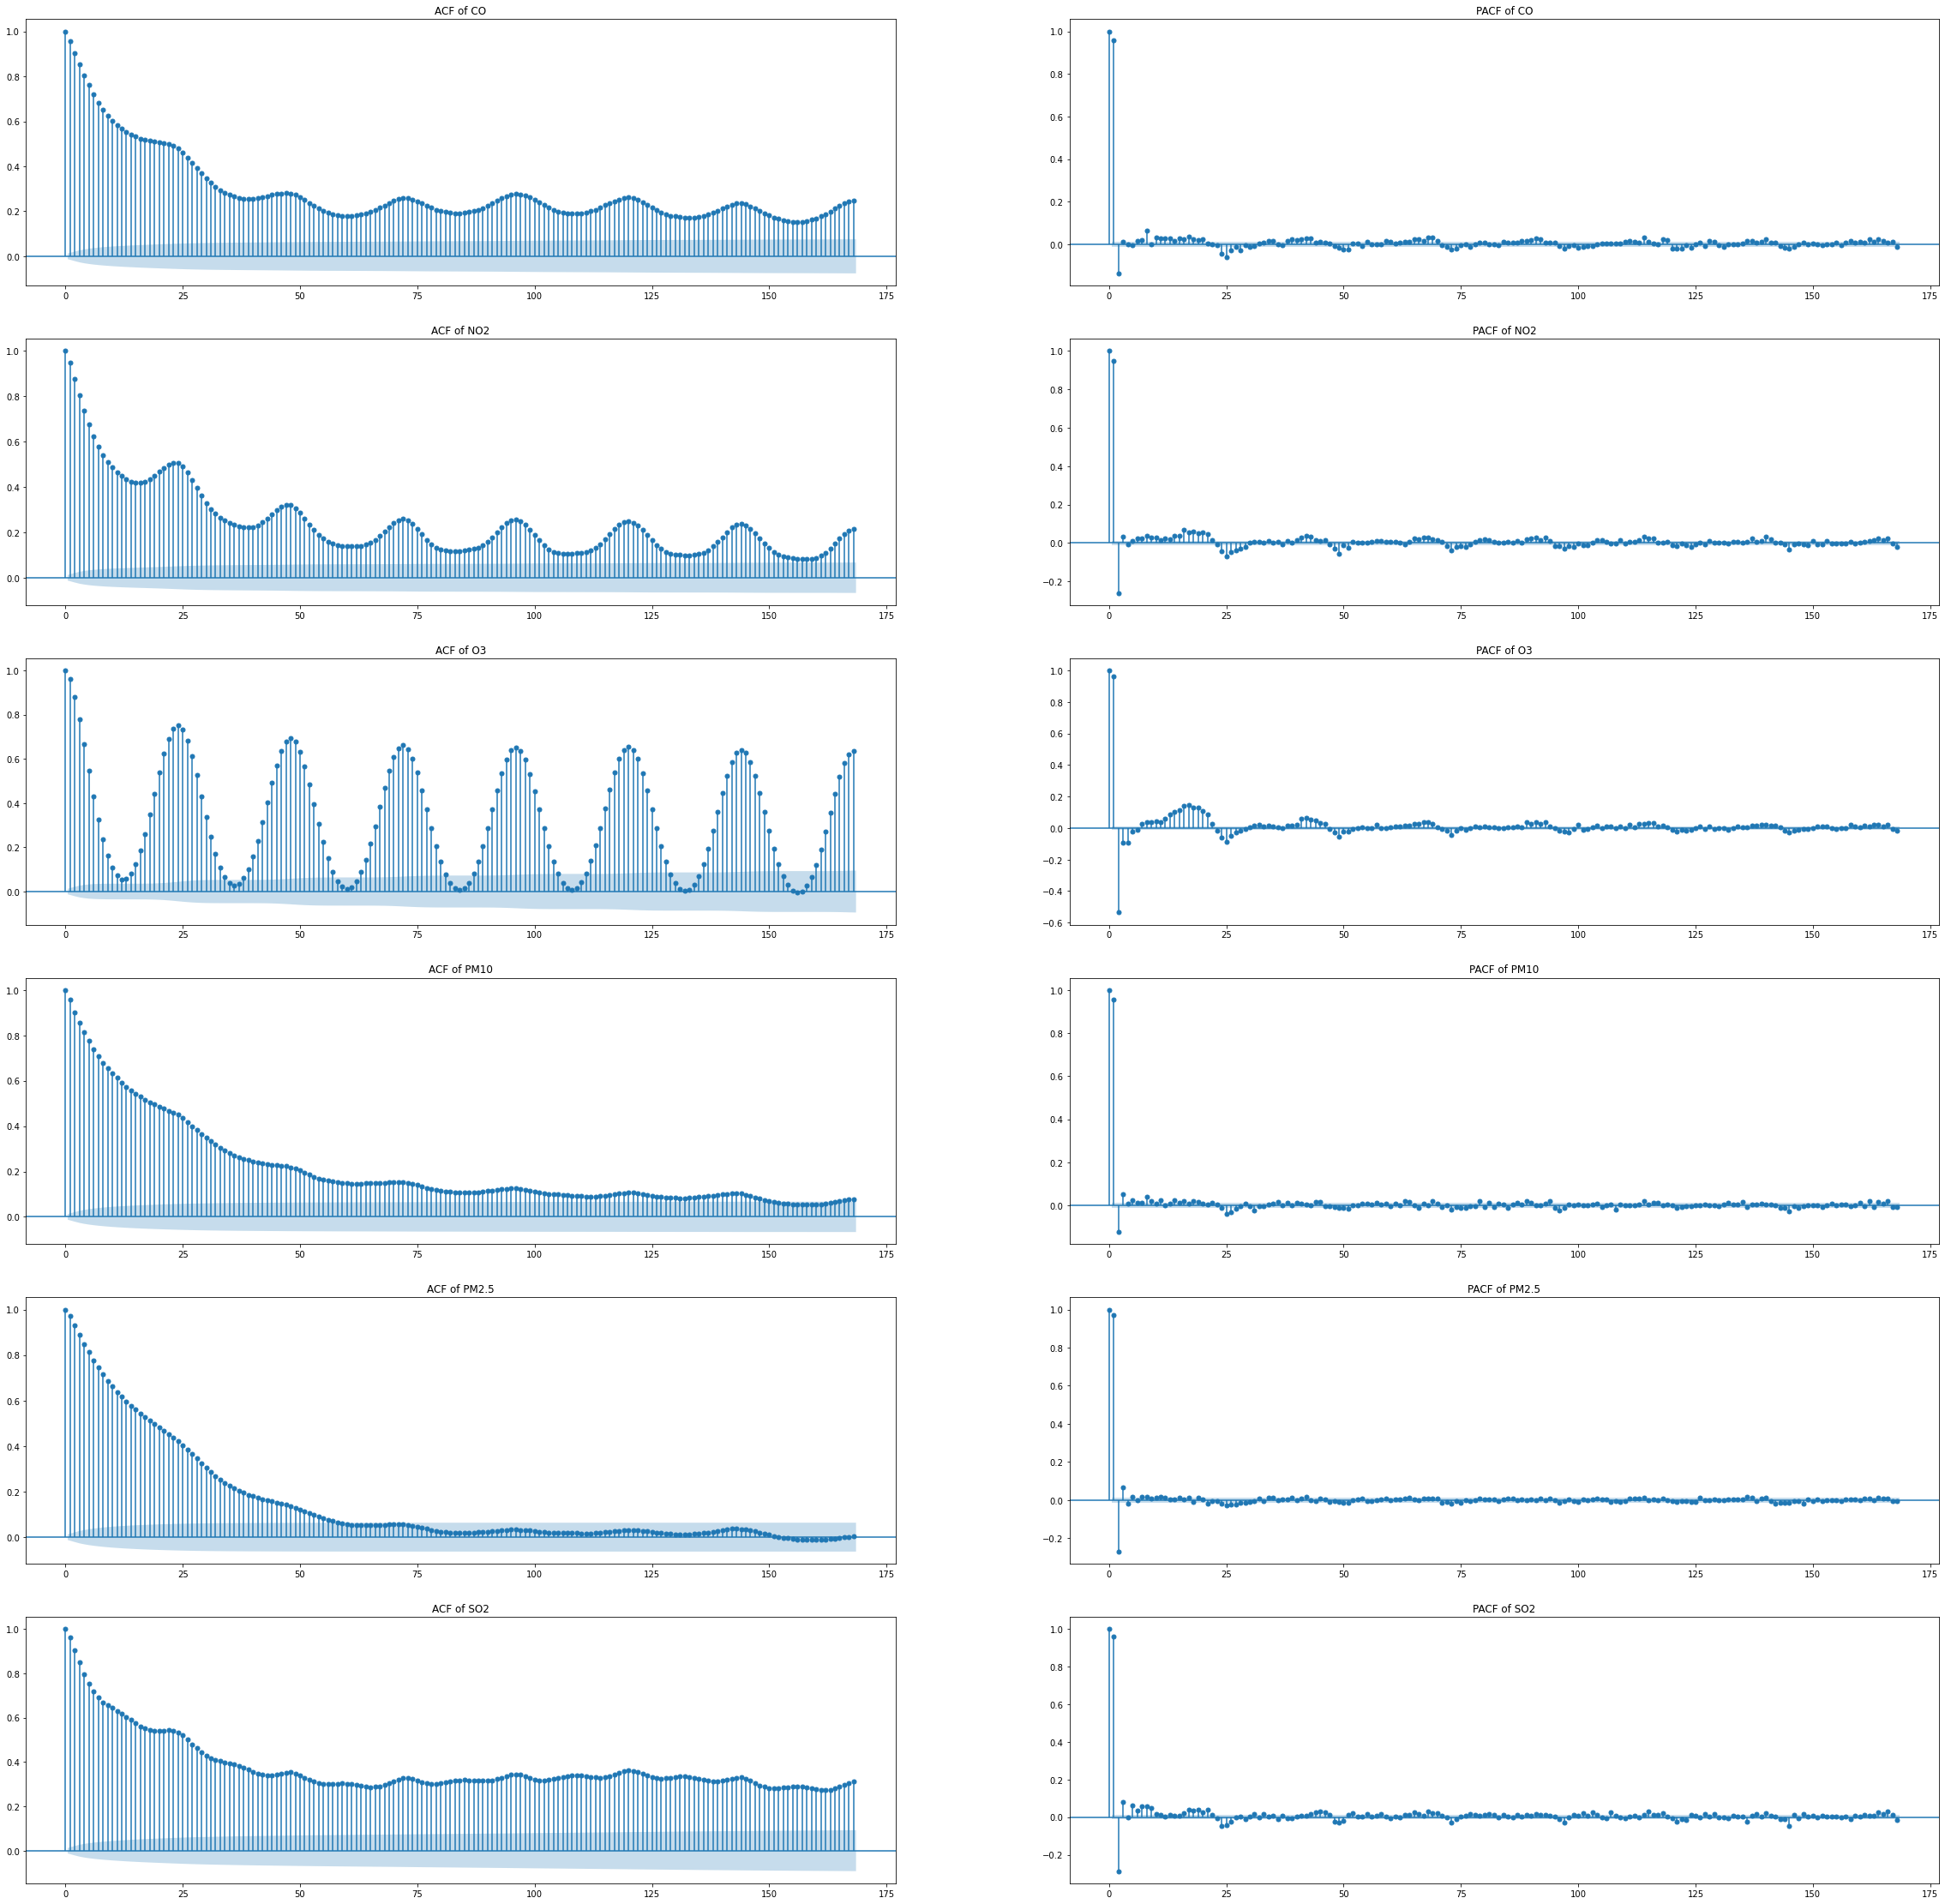

In [44]:
plt.rc("figure", figsize=(40,40))
f, axes = plt.subplots(6, 2)
k = 0
for p in subset_augmented.columns:
    plot_acf(subset_augmented[p],lags=24*7,ax=axes[k][0],title=f"ACF of {p}")
    plot_pacf(subset_augmented[p],lags=24*7,ax=axes[k][1],title=f"PACF of {p}")
    k+=1
plt.show()

In [55]:
res = adfuller(subset_augmented["O3"],maxlag=24*7)

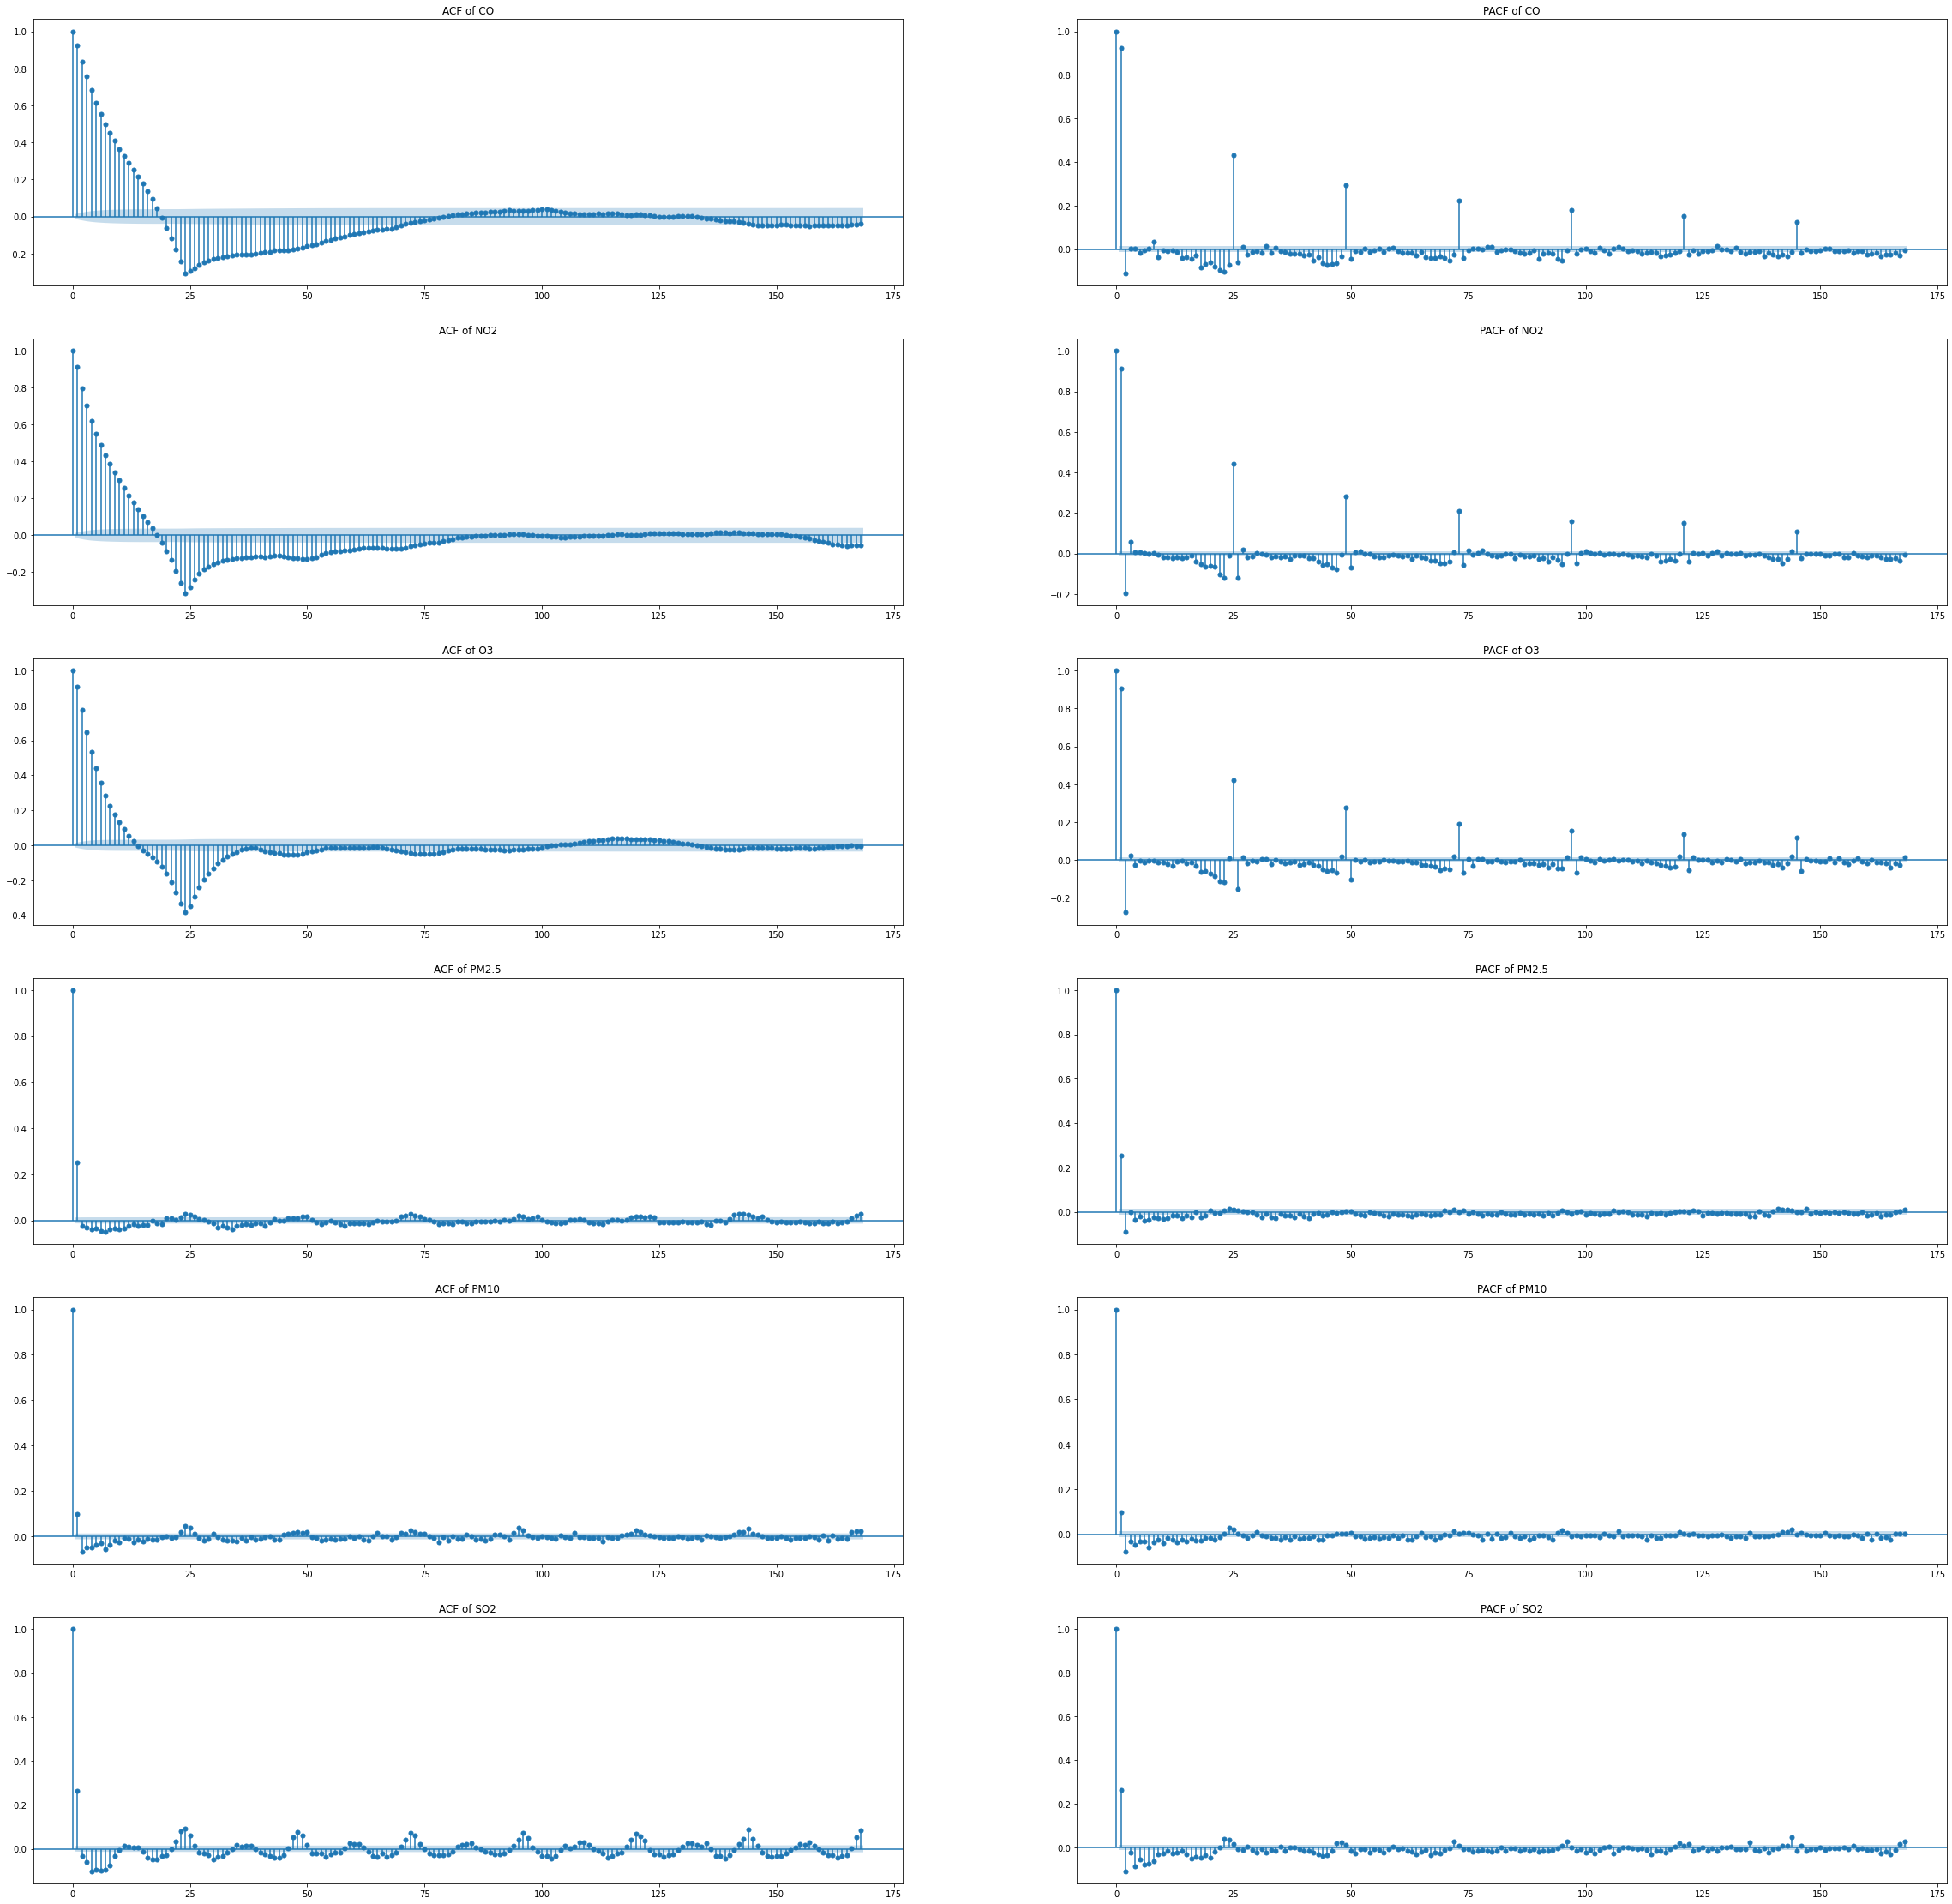

In [95]:
plt.rc("figure", figsize=(40,40))
f, axes = plt.subplots(6, 2)
k = 0
for p in ['CO','NO2','O3']:
    plot_acf((subset_augmented[p]-subset_augmented[p].shift(24)).dropna(),lags=24*7,ax=axes[k][0],title=f"ACF of {p}")
    plot_pacf((subset_augmented[p]-subset_augmented[p].shift(24)).dropna(),lags=24*7,ax=axes[k][1],title=f"PACF of {p}")
    k+=1
for p in ['PM2.5','PM10','SO2']:
    plot_acf((subset_augmented[p]-subset_augmented[p].shift(1)).dropna(),lags=24*7,ax=axes[k][0],title=f"ACF of {p}")
    plot_pacf((subset_augmented[p]-subset_augmented[p].shift(1)).dropna(),lags=24*7,ax=axes[k][1],title=f"PACF of {p}")
    k+=1
plt.show()

In [66]:
subset_augmented["O3"]

Datetime
2014-04-02 12:00:00     95.0
2014-04-02 13:00:00    109.0
2014-04-02 14:00:00    121.0
2014-04-02 15:00:00    125.0
2014-04-02 16:00:00    129.0
                       ...  
2016-12-29 05:00:00      8.0
2016-12-29 06:00:00     18.0
2016-12-29 07:00:00     15.0
2016-12-29 08:00:00      5.0
2016-12-29 09:00:00      8.0
Freq: H, Name: O3, Length: 24046, dtype: float64

In [188]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(subset_augmented[subset_augmented.index<'2016-05-01']["PM2.5"],order=(12, 1, 0))

In [189]:
results=model.fit()

In [190]:
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2623      0.002    164.108      0.000       0.259       0.265
ar.L2         -0.0877      0.003    -33.105      0.000      -0.093      -0.083
ar.L3          0.0061      0.004      1.505      0.132      -0.002       0.014
ar.L4         -0.0437      0.004    -10.512      0.000      -0.052      -0.036
ar.L5         -0.0162      0.003     -4.975      0.000      -0.023      -0.010
ar.L6         -0.0213      0.003     -6.905      0.000      -0.027      -0.015
ar.L7         -0.0338      0.004     -8.556      0.000      -0.042      -0.026
ar.L8         -0.0206      0.005     -4.091      0.000      -0.030      -0.011
ar.L9         -0.0244      0.006     -4.219      0.000      -0.036      -0.013
ar.L10        -0.0299      0.007     -4.529      0.000      -0.043      -0.017
ar.L11        -0.0223      0.007     -3.295      0.0

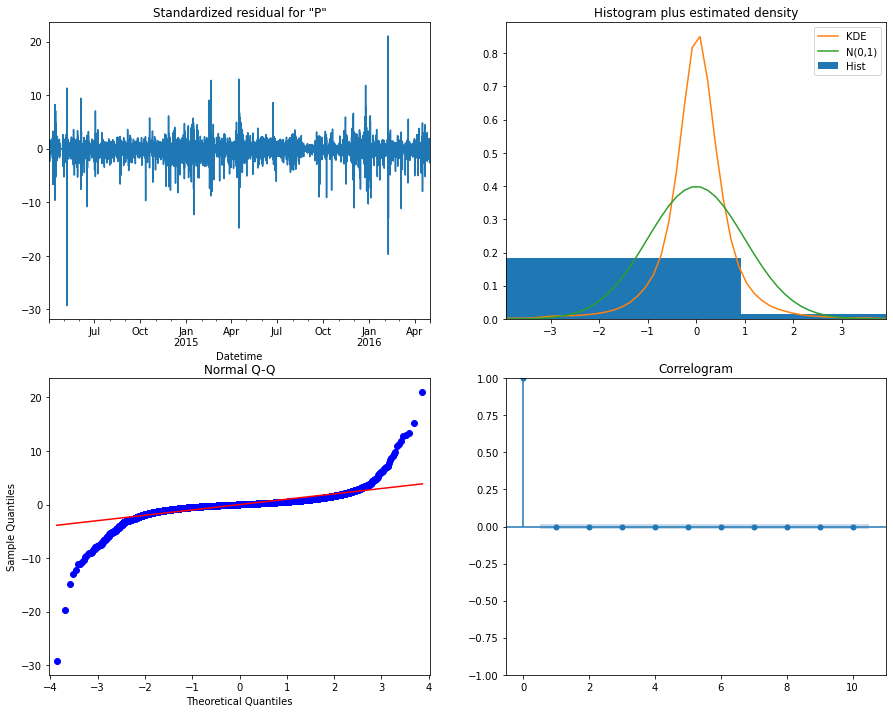

In [191]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [192]:
subset_augmented[subset_augmented.index<'2016-05-01']["PM2.5"]

Datetime
2014-04-02 12:00:00     66.0
2014-04-02 13:00:00     52.0
2014-04-02 14:00:00     65.0
2014-04-02 15:00:00    102.0
2014-04-02 16:00:00    108.0
                       ...  
2016-04-30 19:00:00     81.0
2016-04-30 20:00:00    117.0
2016-04-30 21:00:00    119.0
2016-04-30 22:00:00    139.0
2016-04-30 23:00:00    155.0
Freq: H, Name: PM2.5, Length: 18228, dtype: float64

In [193]:
results.get_forecast(steps=1)._predicted_mean

array([157.20200195])

In [198]:
model = sm.tsa.statespace.SARIMAX(subset_augmented[subset_augmented.index>'2016-05-01']["PM2.5"],order=(12, 1, 0))
res = model.filter(results.params)

In [199]:
model.filter

<bound method MLEModel.filter of <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x00000275F65DB648>>

In [200]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

<AxesSubplot:xlabel='Datetime'>

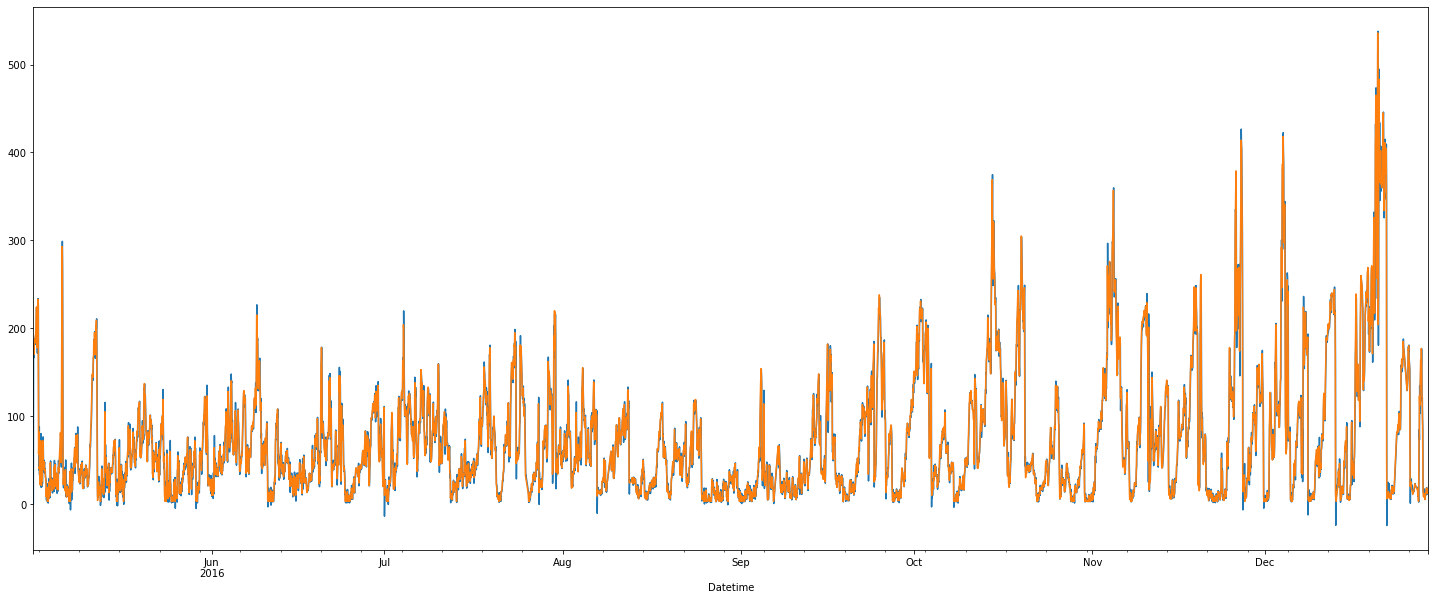

In [201]:
plt.rc("figure", figsize=(25,10))
# f, axes = plt.subplots(6, 2)
predict.predicted_mean.plot()
subset_augmented[subset_augmented.index>'2016-05-01']["PM2.5"].plot()

In [202]:
subset_augmented[subset_augmented.index>'2016-05-01']["PM2.5"]

Datetime
2016-05-01 01:00:00    180.0
2016-05-01 02:00:00    182.0
2016-05-01 03:00:00    170.0
2016-05-01 04:00:00    178.0
2016-05-01 05:00:00    183.0
                       ...  
2016-12-29 05:00:00     12.0
2016-12-29 06:00:00     13.0
2016-12-29 07:00:00     14.0
2016-12-29 08:00:00     14.0
2016-12-29 09:00:00     19.0
Freq: H, Name: PM2.5, Length: 5817, dtype: float64

In [203]:
predict.predicted_mean

Datetime
2016-05-01 01:00:00      0.000000
2016-05-01 02:00:00    180.015366
2016-05-01 03:00:00    182.493238
2016-05-01 04:00:00    166.614459
2016-05-01 05:00:00    181.108137
                          ...    
2016-12-29 05:00:00     14.271906
2016-12-29 06:00:00     11.212573
2016-12-29 07:00:00     13.365516
2016-12-29 08:00:00     13.873449
2016-12-29 09:00:00     13.934327
Freq: H, Name: predicted_mean, Length: 5817, dtype: float64

In [100]:
# !pip install tbats

In [84]:
# from tbats import BATS, TBATS

In [86]:
# # Create estimator
# estimator = TBATS(seasonal_periods=[24, 24*365])

# # Fit model
# fitted_model = estimator.fit(subset_augmented["O3"])

In [204]:
import sklearn
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [205]:
from sklearn.model_selection import TimeSeriesSplit

In [210]:
subset_augmented

,CO,NO2,O3,PM10,PM2.5,SO2
Datetime,,,,,,
2014-04-02 12:00:00,1.0,61.0,95.0,13.0,66.0,15.0
2014-04-02 13:00:00,1.0,58.0,109.0,66.0,52.0,14.0
2014-04-02 14:00:00,1.0,58.0,121.0,125.0,65.0,16.0
2014-04-02 15:00:00,1.0,64.0,125.0,188.0,102.0,24.0
2014-04-02 16:00:00,2.0,67.0,129.0,157.0,108.0,30.0
...,...,...,...,...,...,...
2016-12-29 05:00:00,1.0,59.0,8.0,19.0,12.0,10.0
2016-12-29 06:00:00,0.8,52.0,18.0,18.0,13.0,11.0
2016-12-29 07:00:00,0.8,55.0,15.0,30.0,14.0,12.0


In [255]:
tscv = TimeSeriesSplit(5)
# model = RandomForestRegressor(n_estimators=100)
# model = Ridge(alpha=0.1)
arima_order = (2,1,0)

predicted = pd.DataFrame()
rmse = []

for fold,(train_index, test_index) in enumerate(tscv.split(subset_augmented)):

#     x_train = subset_augmented.loc[subset_augmented.index[train_index],subset_augmented.columns!="target"]
    y_train = subset_augmented.loc[subset_augmented.index[train_index],"PM2.5"]
#     x_test = subset_augmented.loc[subset_augmented.index[test_index],subset_augmented.columns!="target"]
    y_test = subset_augmented.loc[subset_augmented.index[test_index],"PM2.5"]
    
    model = sm.tsa.statespace.SARIMAX(y_train,order=arima_order)
    
    fitted = model.fit()
    print(fitted.summary())
#     print(fitted.coef_,fitted.intercept_)
#     print(f"score is {fitted.score(x_train,y_train)}")
    model = sm.tsa.statespace.SARIMAX(y_test,order=arima_order)
    res = model.filter(fitted.params)

    y_predicted = res.get_prediction().predicted_mean
#     print(y_predicted.values)
    
    predicted = pd.concat([predicted,pd.DataFrame(y_predicted.values,index=subset_augmented.index[test_index], columns=['predicted'])])
#     print(predicted)
    print(f"fold {fold+1}")

    print(f"MAE is {mean_absolute_error(y_test,y_predicted)}")
    print(f"RMSE is {np.sqrt(mean_squared_error(y_test,y_predicted))}")
    rmse.append(np.sqrt(mean_squared_error(y_test,y_predicted)))
#     y_train, y_test = y[train_index], y[test_index]
print(f'rmse over folds is {np.mean(rmse)}')

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\li

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 4011
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -17194.355
Date:                Sun, 06 Feb 2022   AIC                          34394.709
Time:                        17:27:05   BIC                          34413.599
Sample:                    04-02-2014   HQIC                         34401.405
                         - 09-16-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0738      0.004     19.304      0.000       0.066       0.081
ar.L2         -0.1175      0.006    -18.138      0.000      -0.130      -0.105
sigma2       310.4558      1.454    213.587      0.0

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                12025
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -51326.384
Date:                Sun, 06 Feb 2022   AIC                         102658.767
Time:                        17:27:05   BIC                         102680.951
Sample:                    04-02-2014   HQIC                        102666.208
                         - 08-16-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2207      0.002     97.212      0.000       0.216       0.225
ar.L2         -0.0799      0.004    -20.286      0.000      -0.088      -0.072
sigma2       298.7137      0.890    335.764      0.0

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                16032
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -68491.056
Date:                Sun, 06 Feb 2022   AIC                         136988.112
Time:                        17:27:06   BIC                         137011.159
Sample:                    04-02-2014   HQIC                        136995.734
                         - 01-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2692      0.002    139.463      0.000       0.265       0.273
ar.L2         -0.0854      0.003    -25.502      0.000      -0.092      -0.079
sigma2       300.9594      0.758    397.073      0.0

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                20039
Model:               SARIMAX(2, 1, 0)   Log Likelihood              -85815.922
Date:                Sun, 06 Feb 2022   AIC                         171637.845
Time:                        17:27:07   BIC                         171661.561
Sample:                    04-02-2014   HQIC                        171645.603
                         - 07-15-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2659      0.001    199.759      0.000       0.263       0.269
ar.L2         -0.0772      0.002    -44.130      0.000      -0.081      -0.074
sigma2       307.1891      0.512    600.087      0.0

C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
C:\Users\Yao\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [250]:
predicted

,predicted
Datetime,
2014-09-16 15:00:00,0.000000
2014-09-16 16:00:00,31.900666
2014-09-16 17:00:00,32.859422
2014-09-16 18:00:00,39.942363
2014-09-16 19:00:00,40.139615
...,...
2016-12-29 05:00:00,14.246882
2016-12-29 06:00:00,11.506236
2016-12-29 07:00:00,13.246882


In [251]:
tmp=pd.merge(subset_augmented["PM2.5"],predicted,left_index=True,right_index=True)

In [252]:
np.sqrt(mean_squared_error(tmp["PM2.5"],tmp["predicted"]))

17.601504254014323

<AxesSubplot:xlabel='Datetime'>

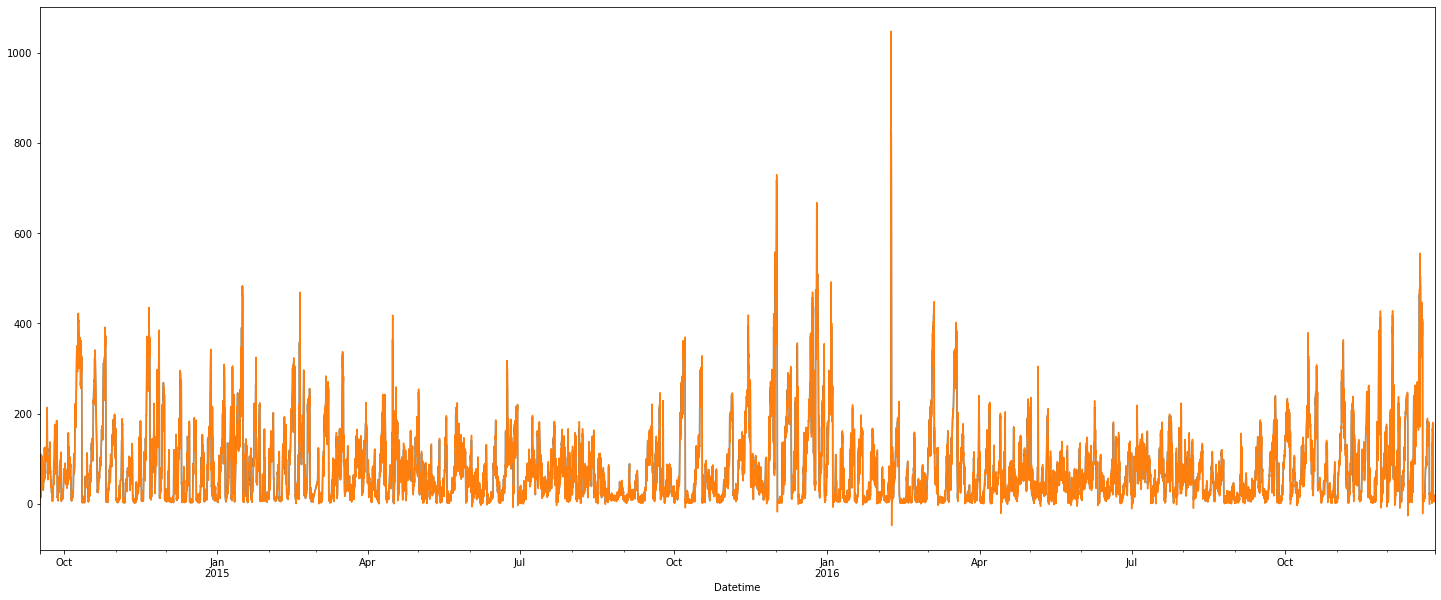

In [253]:
tmp["PM2.5"].plot()
tmp["predicted"].plot()

In [254]:
tmp

,PM2.5,predicted
Datetime,,
2014-09-16 15:00:00,31.9,0.000000
2014-09-16 16:00:00,32.8,31.900666
2014-09-16 17:00:00,39.5,32.859422
2014-09-16 18:00:00,40.1,39.942363
2014-09-16 19:00:00,57.3,40.139615
...,...,...
2016-12-29 05:00:00,12.0,14.246882
2016-12-29 06:00:00,13.0,11.506236
2016-12-29 07:00:00,14.0,13.246882
